# EXP 1

In [10]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

In [11]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

# FMNIST

In [12]:
NUM_EPOCHS = 10
batch_size = 64
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_set = datasets.FashionMNIST('data', train=True, transform=trans, download=True)
test_set = datasets.FashionMNIST('data', train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle=True)

In [13]:
from torchvision import models
from torchsummary import summary

class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.bn  = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

summary(model, input_size = torch.Size([1, 28, 28]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
       BatchNorm2d-2           [-1, 32, 12, 12]              64
            Conv2d-3             [-1, 64, 8, 8]          51,264
            Linear-4                  [-1, 500]         512,500
            Linear-5                   [-1, 10]           5,010
Total params: 569,670
Trainable params: 569,670
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 2.17
Estimated Total Size (MB): 2.39
----------------------------------------------------------------


### 1. Real Net

In [14]:
class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.bn  = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1,
          complexify = False)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.316369	Accuracy: 3.12%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.527469	Accuracy: 68.67%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.438750	Accuracy: 74.84%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.642443	Accuracy: 77.61%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.394197	Accuracy: 79.77%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.377895	Accuracy: 80.90%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.188137	Accuracy: 81.91%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.223596	Accuracy: 82.87%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.299823	Accuracy: 83.52%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.287113	Accuracy: 84.07%
Epoch 0 - Time: 39.45s - Train Loss: 0.436731 - Train Accuracy: 84.24%
Test Loss: 0.360921 - Test Accuracy: 86.76%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.164022	Accuracy: 95.31%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.323505	Accuracy: 89.96%
Train Epoch:   1 [ 12

### 2. Complex Net

In [15]:
class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 32, 5, 1)
        self.bn  = ComplexBatchNorm2d(32)
        self.conv2 = ComplexConv2d(32, 64, 5, 1)
        self.fc1 = ComplexLinear(4*4*64, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*64)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.294536	Accuracy: 17.19%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.364739	Accuracy: 74.95%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.385591	Accuracy: 78.93%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.413919	Accuracy: 81.18%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.276727	Accuracy: 82.50%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.318343	Accuracy: 83.29%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.255105	Accuracy: 84.01%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.334954	Accuracy: 84.46%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.241936	Accuracy: 84.89%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.254197	Accuracy: 85.31%
Epoch 0 - Time: 195.82s - Train Loss: 0.406835 - Train Accuracy: 85.39%
Test Loss: 0.356065 - Test Accuracy: 87.46%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.118702	Accuracy: 98.44%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.234139	Accuracy: 89.68%
Train Epoch:   1 [ 

### 3. Functional changes!

In [16]:
def add_random_small_complex_number(data, small_value=1e-5):
    # Generates a random complex number with small magnitudes
    real_part = torch.randn_like(data.real) * small_value
    imag_part = torch.randn_like(data.imag) * small_value
    small_complex = torch.complex(real_part, imag_part)
    return data + small_complex

def add_fixed_phase(data, phase_value=0.5):
    # Adds a fixed phase to each complex number
    phase_value = torch.tensor(phase_value)
    phase_complex = torch.complex(torch.cos(phase_value), torch.sin(phase_value))
    return data * phase_complex

def add_fixed_imaginary_component(data, imaginary_value=0.1):
    # Adds a fixed imaginary component to each complex number
    real_part = data.real
    imag_part = torch.ones_like(data.imag) * imaginary_value
    return torch.complex(real_part, imag_part)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e3 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e3,
          data_fn = add_random_small_complex_number)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.319439	Accuracy: 9.38%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.338708	Accuracy: 74.12%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.560686	Accuracy: 78.84%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.517458	Accuracy: 80.70%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.330065	Accuracy: 82.25%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.299235	Accuracy: 83.09%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.471952	Accuracy: 83.78%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.303514	Accuracy: 84.28%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.250405	Accuracy: 84.68%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.237533	Accuracy: 85.08%
Epoch 0 - Time: 194.63s - Train Loss: 0.410510 - Train Accuracy: 85.19%
Test Loss: 0.321277 - Test Accuracy: 88.63%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.232330	Accuracy: 90.62%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.296639	Accuracy: 90.04%
Train Epoch:   1 [ 1

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e4 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e4,
          data_fn = add_fixed_imaginary_component)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e4.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.323378	Accuracy: 10.94%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.492604	Accuracy: 74.97%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.393423	Accuracy: 79.25%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.607883	Accuracy: 81.23%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.391529	Accuracy: 82.32%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.418127	Accuracy: 83.19%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.515711	Accuracy: 83.76%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.482905	Accuracy: 84.32%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.237191	Accuracy: 84.78%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.339538	Accuracy: 85.16%
Epoch 0 - Time: 391.19s - Train Loss: 0.405236 - Train Accuracy: 85.32%
Test Loss: 0.363892 - Test Accuracy: 86.84%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.166403	Accuracy: 93.75%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.207056	Accuracy: 90.35%
Train Epoch:   1 [ 

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e5 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e5,
          data_fn = add_fixed_phase)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e5.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.262881	Accuracy: 20.31%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.456300	Accuracy: 74.18%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.672776	Accuracy: 78.77%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.365163	Accuracy: 80.88%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.491465	Accuracy: 82.26%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.428120	Accuracy: 83.06%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.383953	Accuracy: 83.82%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.237148	Accuracy: 84.36%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.338269	Accuracy: 84.75%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.380098	Accuracy: 85.22%
Epoch 0 - Time: 191.52s - Train Loss: 0.407611 - Train Accuracy: 85.32%
Test Loss: 0.486761 - Test Accuracy: 82.24%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.285193	Accuracy: 92.19%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.320579	Accuracy: 90.24%
Train Epoch:   1 [ 

# Plots

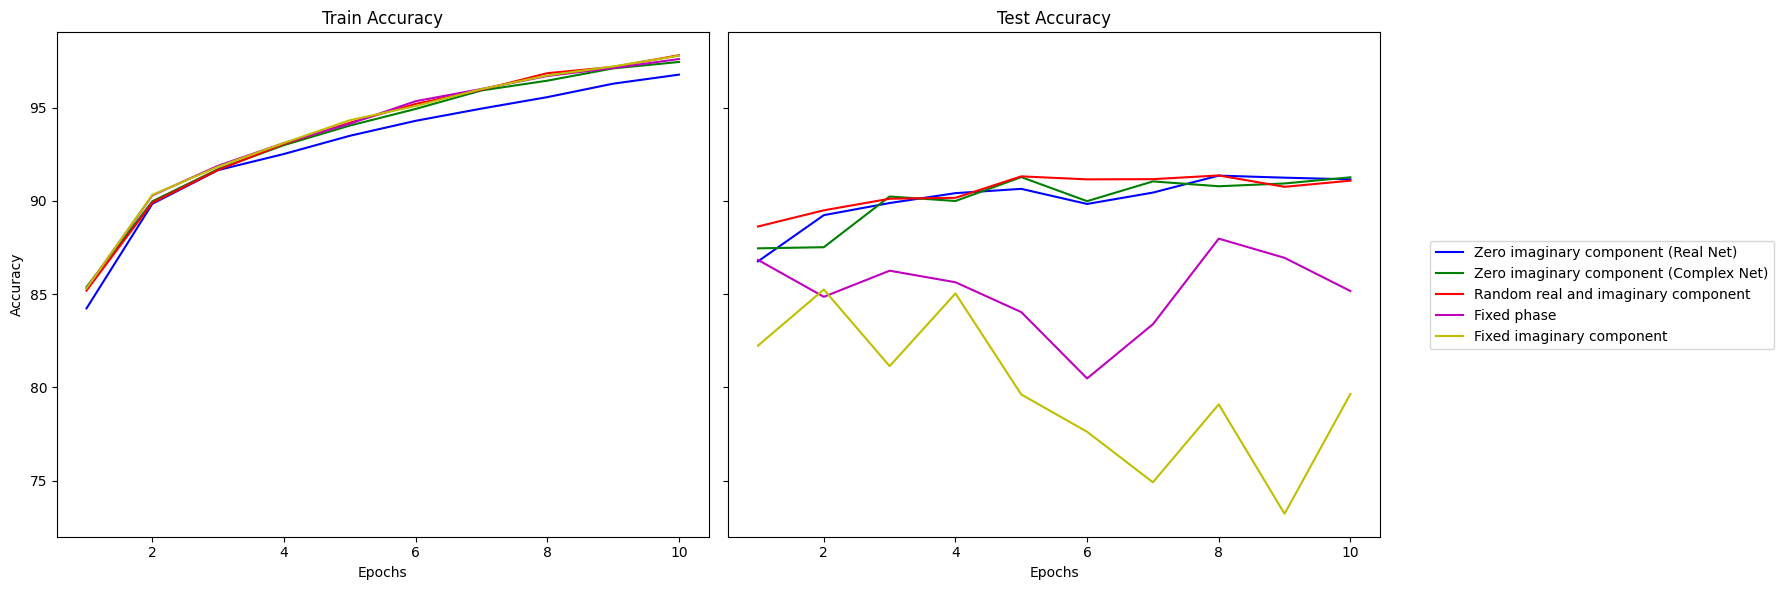

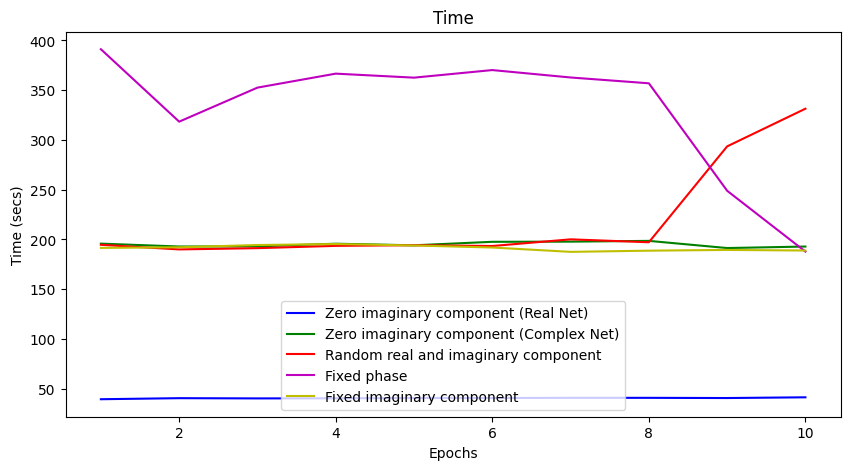

In [47]:
# Data for the five scenarios
data = {
    "Zero imaginary component (Real Net)": metrics_dict_e1,
    "Zero imaginary component (Complex Net)": metrics_dict_e2,
    "Random real and imaginary component": metrics_dict_e3,
    "Fixed phase": metrics_dict_e4,
    "Fixed imaginary component": metrics_dict_e5
}

# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y']
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
for i, scenario in enumerate(scenarios):
    axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
axes.set_title("Time")
axes.set_xlabel("Epochs")
axes.set_ylabel("Time (secs)")
axes.legend()


In [24]:
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss (log scale)")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].set_yscale('log')
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss (log scale)")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].set_yscale('log')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

### Activation Comparison

In [ ]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)  
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd

# ---------- Complex Activation Functions ----------
def complex_relu(z):
    return F.relu(z.real).type(torch.complex64) + 1j * F.relu(z.imag).type(torch.complex64)

def modrelu(z, b=0.1):
    magnitude = torch.abs(z)
    phase = z / (magnitude + 1e-8)
    scale = F.relu(magnitude + b)
    return scale * phase

def zrelu(z):
    mask = (z.real >= 0) & (z.imag >= 0)
    return z * mask

def smooth_zrelu(z, alpha=0.5):
    real_mask = torch.sigmoid(alpha * z.real)
    imag_mask = torch.sigmoid(alpha * z.imag)
    smooth_mask = real_mask * imag_mask
    return z * smooth_mask

def split_tanh(z):
    return torch.tanh(z.real).type(torch.complex64) + 1j * torch.tanh(z.imag).type(torch.complex64)

def complex_cardioid(z, eps=1e-5):
    norm = torch.abs(z)
    cos_phase = z.real / (norm + eps)  # cos(theta)
    scale = 0.5 * (1 + cos_phase)
    return z * scale

# ---------- Data Transformations ----------
def add_random_small_complex_number(data, small_value=1e-5):
    real_part = torch.randn_like(data.real) * small_value
    imag_part = torch.randn_like(data.imag) * small_value
    return data + torch.complex(real_part, imag_part)

def add_fixed_phase(data, phase_value=0.5):
    phase_complex = torch.complex(torch.cos(torch.tensor(phase_value)), torch.sin(torch.tensor(phase_value)))
    return data * phase_complex

def add_fixed_imaginary_component(data, imaginary_value=0.1):
    real_part = data.real
    imag_part = torch.ones_like(data.imag) * imaginary_value
    return torch.complex(real_part, imag_part)

# ---------- Model ----------
class ComplexNet(nn.Module):
    def __init__(self, activation_fn):
        super(ComplexNet, self).__init__()
        self.activation_fn = activation_fn
        self.conv1 = ComplexConv2d(1, 32, 5, 1)
        self.bn  = ComplexBatchNorm2d(32)
        self.conv2 = ComplexConv2d(32, 64, 5, 1)
        self.fc1 = ComplexLinear(4*4*64, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

# ---------- Evaluation Function ----------
def evaluate_combination(activation_name, activation_fn, data_fn_name, data_fn, NUM_EPOCHS=5):
    model = ComplexNet(activation_fn).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    metrics_dict = {
        'epoch_times': [],
        'train_losses': [],
        'train_accuracies': [],
        'test_losses': [],
        'test_accuracies': []
    }

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Activation: {activation_name}, Data Transformation: {data_fn_name}")
        train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict,
              complexify=True, data_fn=data_fn)

    return {
        'Activation': activation_name,
        'Data Transformation': data_fn_name,
        'Train Loss': sum(metrics_dict['train_losses']) / NUM_EPOCHS,
        'Train Accuracy': sum(metrics_dict['train_accuracies']) / NUM_EPOCHS,
        'Test Loss': sum(metrics_dict['test_losses']) / NUM_EPOCHS,
        'Test Accuracy': sum(metrics_dict['test_accuracies']) / NUM_EPOCHS,
        'Avg Epoch Time (s)': sum(metrics_dict['epoch_times']) / NUM_EPOCHS
    }

# ---------- Setup ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

activation_functions = {
    "CReLU": complex_relu,
    "modReLU": lambda z: modrelu(z, b=0.1),
    "zReLU": smooth_zrelu,
    "split_tanh": split_tanh,
    "cardioid": complex_cardioid
}

data_transformations = {
    "None": None,
    "Small Random Complex Noise": add_random_small_complex_number,
    "Fixed Phase (0.5)": add_fixed_phase,
    "Fixed Imaginary (0.1)": add_fixed_imaginary_component
}

In [50]:
results = []

act_name = "CReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_crelu = pd.DataFrame(results)

Running: Activation = CReLU, Data Transform = None
Epoch 1/5 - Activation: CReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.350418	Accuracy: 6.25%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.560494	Accuracy: 74.55%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.444289	Accuracy: 79.28%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.207793	Accuracy: 81.24%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.315463	Accuracy: 82.46%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.516465	Accuracy: 83.20%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.233794	Accuracy: 83.85%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.229901	Accuracy: 84.49%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.248351	Accuracy: 84.97%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.285754	Accuracy: 85.35%
Epoch 0 - Time: 185.31s - Train Loss: 0.401987 - Train Accuracy: 85.41%
Test Loss: 0.345202 - Test Accuracy: 87.22%

Epoch 2/5 - Activation: CReLU, Data Transformation: None

In [51]:
results = []

act_name = "modReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_modrelu = pd.DataFrame(results)

Running: Activation = modReLU, Data Transform = None
Epoch 1/5 - Activation: modReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.488110	Accuracy: 12.50%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 1.431513	Accuracy: 70.00%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.468784	Accuracy: 72.89%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.410722	Accuracy: 74.10%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.829825	Accuracy: 75.26%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.881810	Accuracy: 75.90%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.513335	Accuracy: 76.68%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.785340	Accuracy: 77.39%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.495017	Accuracy: 78.12%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.465609	Accuracy: 78.73%
Epoch 0 - Time: 205.62s - Train Loss: 0.747542 - Train Accuracy: 78.87%
Test Loss: 0.530523 - Test Accuracy: 82.78%

Epoch 2/5 - Activation: modReLU, Data Transformatio

In [65]:
results = []

act_name = "zReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_zrelu = pd.DataFrame(results)

Running: Activation = zReLU, Data Transform = None
Epoch 1/5 - Activation: zReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.306981	Accuracy: 9.38%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.609163	Accuracy: 67.98%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.384188	Accuracy: 74.95%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.410751	Accuracy: 77.79%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.442209	Accuracy: 79.73%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.288083	Accuracy: 80.90%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.294280	Accuracy: 81.89%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.610824	Accuracy: 82.71%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.477387	Accuracy: 83.39%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.303114	Accuracy: 83.83%
Epoch 0 - Time: 9352.38s - Train Loss: 0.457171 - Train Accuracy: 83.98%
Test Loss: 0.328903 - Test Accuracy: 88.16%

Epoch 2/5 - Activation: zReLU, Data Transformation: Non

In [53]:
results = []

act_name = "split_tanh"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_split_tanh = pd.DataFrame(results)

Running: Activation = split_tanh, Data Transform = None
Epoch 1/5 - Activation: split_tanh, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.368146	Accuracy: 7.81%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.615909	Accuracy: 72.23%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.508908	Accuracy: 76.91%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.336603	Accuracy: 78.60%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.390976	Accuracy: 80.06%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.245614	Accuracy: 81.02%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.386990	Accuracy: 81.87%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.364091	Accuracy: 82.41%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.425380	Accuracy: 82.93%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.185348	Accuracy: 83.44%
Epoch 0 - Time: 195.23s - Train Loss: 0.457977 - Train Accuracy: 83.53%
Test Loss: 0.435560 - Test Accuracy: 84.90%

Epoch 2/5 - Activation: split_tanh, Data Trans

In [68]:
results = []

act_name = "cardioid"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_cardioid = pd.DataFrame(results)

Running: Activation = cardioid, Data Transform = None
Epoch 1/5 - Activation: cardioid, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.320892	Accuracy: 9.38%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.447868	Accuracy: 75.14%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.395027	Accuracy: 79.41%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.535442	Accuracy: 81.47%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.357271	Accuracy: 82.78%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.186416	Accuracy: 83.79%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.371998	Accuracy: 84.51%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.190867	Accuracy: 85.09%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.386497	Accuracy: 85.50%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.340449	Accuracy: 85.85%
Epoch 0 - Time: 380.80s - Train Loss: 0.385491 - Train Accuracy: 86.00%
Test Loss: 0.323854 - Test Accuracy: 88.41%

Epoch 2/5 - Activation: cardioid, Data Transformat

In [69]:
df_results = pd.concat([df_crelu, df_modrelu, df_zrelu, df_split_tanh, df_cardioid], ignore_index=True)
print("\nFinal Results Summary:\n")
print(df_results.to_string(index=False))


Final Results Summary:

Activation        Data Transformation  Train Loss  Train Accuracy  Test Loss  Test Accuracy  Avg Epoch Time (s)
     CReLU                       None    0.247005       90.923333   0.297585         89.758          190.049954
     CReLU Small Random Complex Noise    0.250762       90.786333   0.290666         89.726          194.794372
     CReLU          Fixed Phase (0.5)    0.248116       90.899667   0.652634         78.372          191.310758
     CReLU      Fixed Imaginary (0.1)    0.250788       90.775000   0.381201         86.152          191.076632
   modReLU                       None    0.422216       86.317667   0.398871         86.452          208.144897
   modReLU Small Random Complex Noise    0.430132       86.125667   0.399982         86.406          210.441375
   modReLU          Fixed Phase (0.5)    0.426227       86.205333   0.784470         74.136          208.046571
   modReLU      Fixed Imaginary (0.1)    0.424018       86.408000   0.528151   